In [5]:
from influxdb import InfluxDBClient # install via "pip install influxdb"
import pandas as pd
import math
#this is a comment

client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df



In [6]:
# Get the last 90 days of power generation data
generation = client.query(
    "SELECT * FROM Generation where time > now()-90d Order by time desc"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1' Order by time desc"
    ) # Query written in InfluxQL

gen_df = get_df(generation)
wind_df = get_df(wind)
wind_df.replace({
    "N":math.radians(0), 
    "NNE":math.radians(22.5), 
    "NE":math.radians(45),
    "ENE":math.radians(67.5),
    "E":math.radians(90), 
    "ESE":math.radians(111.5), 
    "SE":math.radians(135), 
    "SSE":math.radians(157.5),
    "S":math.radians(180), 
    "SSW":math.radians(202.5), 
    "SW":math.radians(225), 
    "WSW":math.radians(247.5), 
    "W":math.radians(270), 
    "WNW":math.radians(292.5), 
    "NW":math.radians(315), 
    "NNW":math.radians(337.5)}, 
    inplace=True)


&lt;matplotlib.axes._subplots.AxesSubplot at 0x1652dc38cc8&gt;

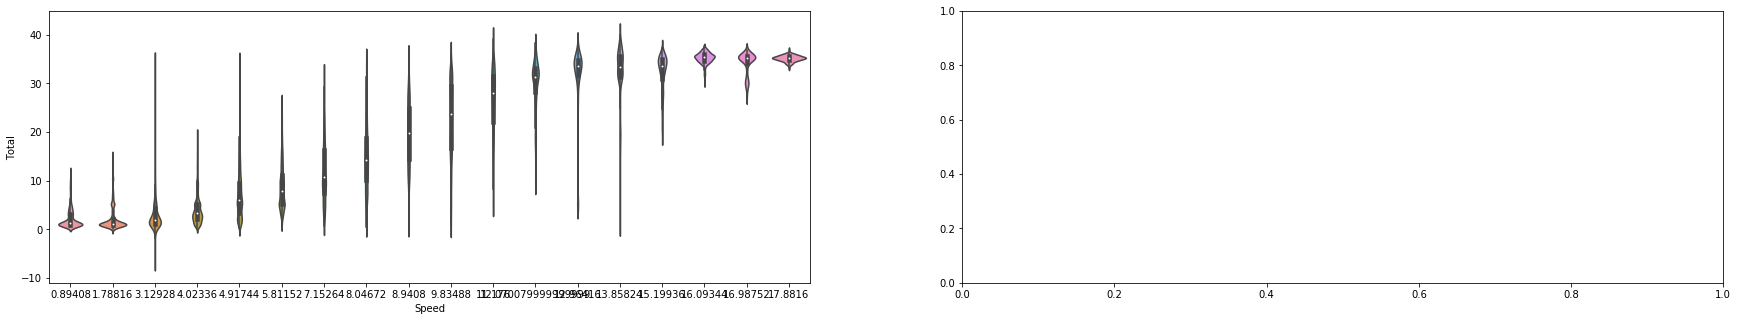

In [7]:
import math
df_aligned = pd.concat([wind_df, gen_df], axis=1, join='outer').fillna(method='ffill').fillna(method='bfill')

import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=2, figsize=(30,5))
sns.violinplot(x="Speed", y="Total", data=df_aligned, ax=axs[0])


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Align the data frames

'''pipeline = Pipeline([
    # This is your job - make a pipeline.
    # This is also where you add your model
])'''

# Fit the pipeline

&#39;pipeline = Pipeline([\n    # This is your job - make a pipeline.\n    # This is also where you add your model\n])&#39;